# Original Image

C:\Users\vduec\AppData\Local\Temp\ipykernel_19964\2807922832.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


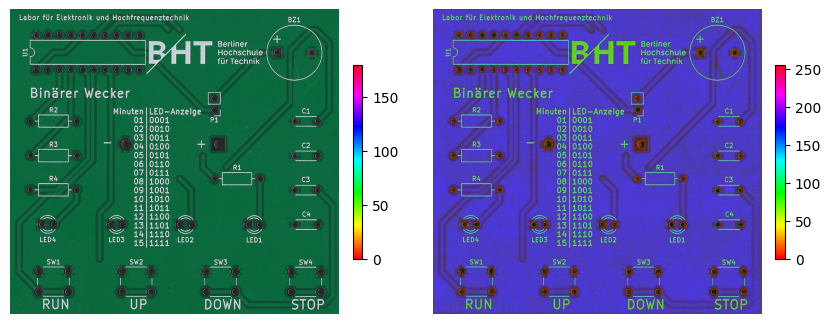

In [3]:


import cv2
import matplotlib.pyplot as plt
import numpy as np

path = 'images/pcbs/0001_bin_alarm/base_top.png'
# create figure and axis
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# read image as HSL (hue, saturation, lightness)
img = cv2.imread(path, cv2.IMREAD_COLOR)
imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
idx = 2
rgb = cv2.cvtColor(imgHSV, cv2.COLOR_HLS2RGB)
im = axs[0].imshow(rgb, cmap='hsv', vmin=0, vmax=180)
cbar = fig.colorbar(im, ax=axs[0], fraction=0.0275, pad=0.04)
axs[0].axis('off')

# apply clahe to saturation channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
imgHSV[:,:,idx] = clahe.apply(imgHSV[:,:,idx])

# apply median blur to saturation channel
#imgHSV[:,:,idx] = cv2.medianBlur(imgHSV[:,:,idx], 9)
rgb = cv2.cvtColor(imgHSV, cv2.COLOR_HLS2RGB)
im = axs[1].imshow(imgHSV, cmap='hsv', vmin=0, vmax=255)
cbar = fig.colorbar(im, ax=axs[1], fraction=0.0275, pad=0.04)
axs[1].axis('off')
fig.show()








# White Mask

True

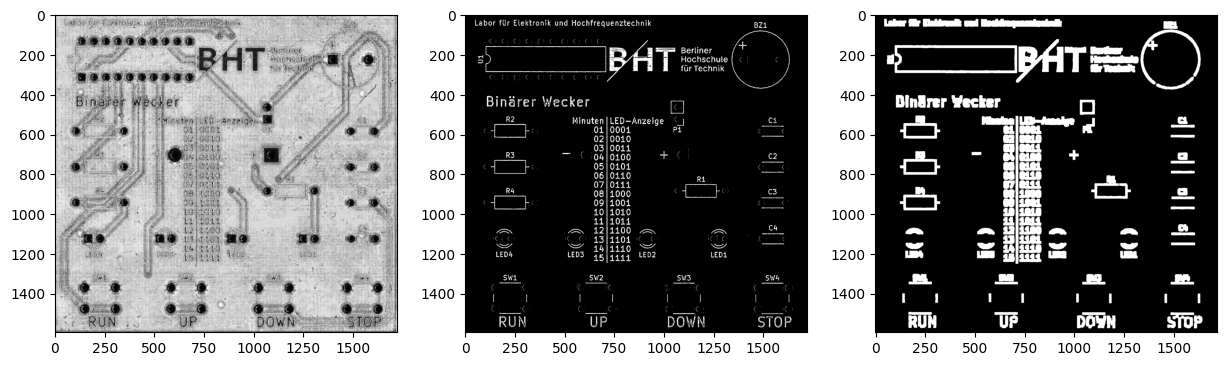

In [4]:
# thresholding
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
path = 'images/pcbs/0001_bin_alarm/base_top.png'
img = cv2.imread(path, cv2.IMREAD_COLOR)
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, imgThresh = cv2.threshold(imgGray,200,255,cv2.THRESH_BINARY)
# dilate
kernel = np.ones((3,3),np.uint8)
imgErode = cv2.erode(imgThresh, kernel, iterations=1)
kernel = np.ones((5,5),np.uint8)
imgDilate = cv2.dilate(imgErode, kernel, iterations=3)
#imgDilate = cv2.dilate(imgErode, kernel, iterations=9)
whiteMask = cv2.medianBlur(imgDilate, 3)
#
axs[0].imshow(imgHSV[:,:,2], cmap='gray')
axs[1].imshow(imgThresh, cmap='gray')
axs[2].imshow(whiteMask, cmap='gray')

cv2.imwrite("images/pcbs/0001_bin_alarm/inpaint_mask.png", whiteMask)

# Inpainting

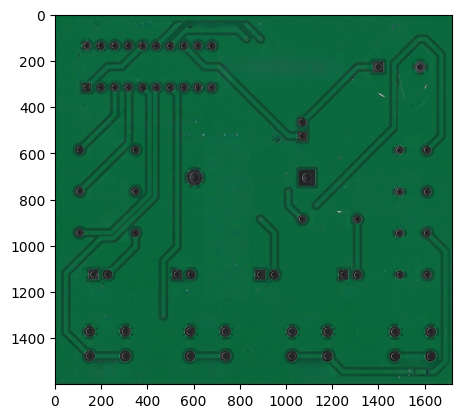

In [6]:
from simple_lama_inpainting import SimpleLama
import cv2
import numpy as np
import matplotlib.pyplot as plt

simple_lama = SimpleLama()

img_path = "images/pcbs/0001_bin_alarm/base_top.png"
mask_path = "images/pcbs/0001_bin_alarm/inpaint_mask_top.png"

image = cv2.imread(img_path,cv2.IMREAD_COLOR)
mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

inpaint = simple_lama(image, mask)
inpaint = np.array(inpaint)

#inpaint = cv2.imread("inpainted.png")
#inpaint = cv2.erode(inpaint, kernel, iterations=1)
cv2.imwrite("inpainted.png", inpaint)
plt.imshow(cv2.cvtColor(inpaint, cv2.COLOR_BGR2RGB))
plt.show()

# Pad Seperation

C:\Users\vduec\AppData\Local\Temp\ipykernel_19964\2165256452.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


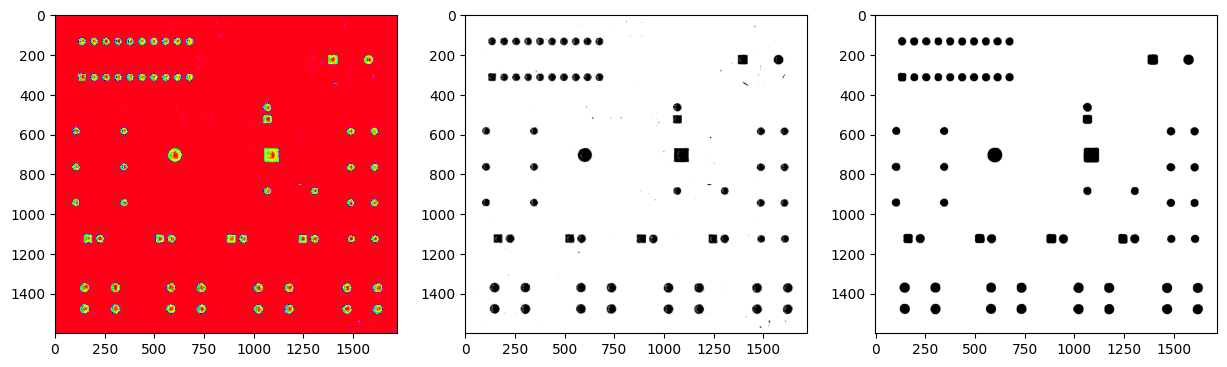

In [7]:
# read image as HSL (hue, saturation, lightness)
path = 'images/pcbs/0001_bin_alarm/inpainted_top.png'
img = cv2.imread(path, cv2.IMREAD_COLOR)
imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# otsu thresholding
_, imgThresh = cv2.threshold(imgHSV[:,:,1],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imgBlur = cv2.medianBlur(imgThresh, 15)
padMask = cv2.erode(imgBlur, kernel, iterations=1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(imgHSV[:,:,1], cmap='hsv', vmin=0, vmax=180)
axs[1].imshow(imgThresh, cmap='gray')
axs[2].imshow(padMask, cmap='gray')
cv2.imwrite('images/pcbs/0001_bin_alarm/pad_mask_top.png', padMask)
fig.show()

# Pad Removal

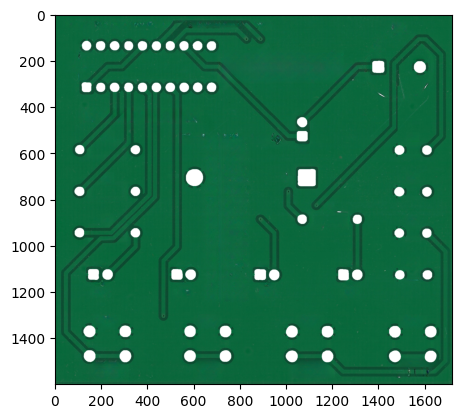

True

In [8]:
img = cv2.imread("images/pcbs/0001_bin_alarm/inpainted_top.png", cv2.IMREAD_COLOR)
pad_mask = cv2.imread("images/pcbs/0001_bin_alarm/pad_mask_top.png", cv2.IMREAD_GRAYSCALE)
img[pad_mask == 0] = 255

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite("images/pcbs/0001_bin_alarm/pad_removal_top.png", img)

# Clustering

C:\Users\vduec\AppData\Local\Temp\ipykernel_19964\2632878749.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


True

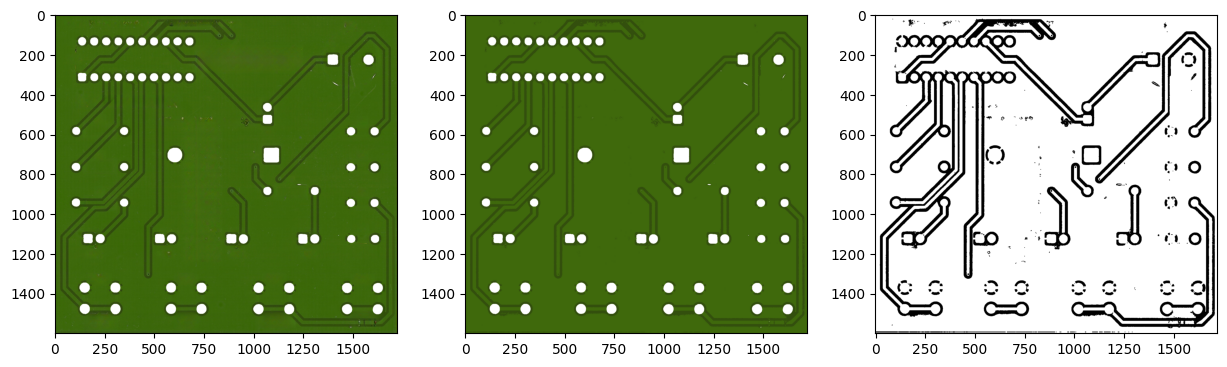

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("images/pcbs/0001_bin_alarm/pad_removal_top.png", cv2.IMREAD_COLOR)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# thresholding
#imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#imgGray = cv2.medianBlur(imgGray, 19)
#_, imgThresh = cv2.threshold(imgGray,68,255,cv2.THRESH_BINARY)
#kernel = np.ones((3,3),np.uint8)
#imgErode = cv2.erode(imgThresh, kernel, iterations=0)
# blur 

# clusterring
Z = img.reshape((-1,3))
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

# thresholding
imgGray = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
_, imgThresh = cv2.threshold(imgGray,68,255,cv2.THRESH_BINARY)
kernel = np.ones((3,3),np.uint8)
imgErode = cv2.erode(imgThresh, kernel, iterations=1)
imgBlur = cv2.medianBlur(imgErode, 1)


axs[0].imshow(img, cmap='hsv')
axs[1].imshow(res2, cmap='hsv')
axs[2].imshow(imgErode, cmap='gray')
fig.show()
cv2.imwrite('images/pcbs/0001_bin_alarm/trace_mask_top.png', imgBlur)

# Trace Contours

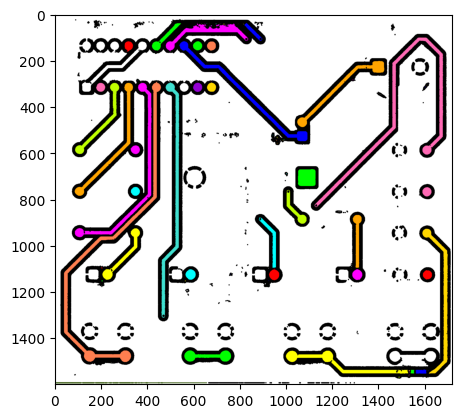

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("images/pcbs/0001_bin_alarm/trace_mask_top.png", cv2.IMREAD_GRAYSCALE)

colors = [(255, 255, 255), (0, 0, 0)]

trace_colors = [
                (0, 255, 0), # 
                (0, 0, 255), 
                (255, 0, 0),
                (255, 255, 0), # yellow
                (0, 255, 255), #cyan
                (255, 0, 255), # magenta
                (255, 165, 0), # orange 
                (191, 255, 0), # lime
                (255, 105, 180), # pink
                (148, 0, 211), # violett
                (255, 215, 0), # gold
                (64, 224, 208), # turqouise
                (255, 127, 80), # coral

]

# Konturen durchlaufen und zeichnen
def draw_contours_by_level(image, contours, hierarchy, colors):
    trace_counter = 0
    for i, _ in enumerate(contours):
        # Bestimme das Level der aktuellen Kontur
        level = 0
        h = hierarchy[0][i]
        while h[3] != -1:
            level += 1
            h = hierarchy[0][h[3]]
        
        # Wähle die Farbe basierend auf dem Level
        color = colors[min(level, len(colors) - 1)]  # Sicherstellen, dass wir die Liste nicht überschreiten
        
        # Zeichne die Konturen auf dem Bild
        if level == 2:
            t_color = trace_colors[trace_counter % len(trace_colors)]  # Zufällige Farbe
            cv2.drawContours(img, contours, i, t_color, -1)  # Kontur füllen (-1 für Füllung)
            trace_counter = trace_counter + 1
        else:
            cv2.drawContours(image, contours, i, color, -1)  # 2 ist die Dicke der Kontur
    return image

# find contours
contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# draw contours
img = cv2.imread("images/pcbs/0001_bin_alarm/pad_removal_top.png", cv2.IMREAD_COLOR)
draw_contours_by_level(img, contours, hierarchy, colors)
plt.imshow(img)